In [12]:
#필요한 것들 import 
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision
from torchvision import transforms,datasets, models
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import time
import tqdm 

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
#image data를 한번에 변형시키는 틀 
#사이즈조정
#ToTensor : pixels값들을 0-255에서 0-1로 자동변환
trans = transforms.Compose([transforms.Resize((224,224)), 
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5,0.5,0.5))])



In [4]:
#imagefolder를 사용하기 위해선 기본적인 디렉토리 골격을 지켜야
#제일 하위 디렉토리가 클래스명으로 이루어져야
#
data_dir  = 'C:/Users/User/Desktop/plantdata/'
train_datasets = datasets.ImageFolder(data_dir+'train', trans)
test_datasets = datasets.ImageFolder(data_dir+'test', trans)


In [5]:
train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size= 16, shuffle=True,num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size= 16, shuffle=True,num_workers=4)


print('학습 데이터셋 크기:', len(train_datasets))
print('테스트 데이터셋 크기:', len(test_datasets))


학습 데이터셋 크기: 55017
테스트 데이터셋 크기: 14357


In [6]:
classes = train_datasets.classes
classes

['Acorus gramineus',
 'Adiantum raddianum',
 'Aglaonema commutatum',
 "Alpinia zerumbet 'Variegata'",
 'Asparagus pulmosus var. nanus',
 'Aspidistra elatior',
 'Asplenium nidus',
 'Aucuba japonica  var. variegata',
 'Beaucarnea recurvata (Nolina tuberculata)',
 'Begonia rex',
 'Begonia semperflorens',
 'Caladium bicolor (hortulantum) Vent',
 'Calathea makoyana',
 'Camellia japonica',
 'Chlorophytum comosum',
 'Chrysalidocarpus lutescens',
 'Clivia miniata',
 'Codiaeum variegatum',
 'Cryptanthus spp',
 'Cyrtomium falcatum',
 'Dendrobium phalaenopsis',
 "Dieffenbachia amoena 'Tropic snow'",
 'Epipremnum aureum',
 'Euonymus japonica',
 'Euphorbia pulcherrima',
 "Fatshedera lizei 'Variegata'",
 "Ficus elastica 'Robusta'",
 "Ficus elastica 'Sofia'",
 "Ficus microcarpa 'Ginseng'",
 "Ficus pumila 'Variegata'",
 "Glecoma hederacea 'Variegata'",
 'Hedera helix',
 'Hemionitis arifolia',
 "Impatiens hybrid 'New Guinea'",
 'Monstera deliciosa',
 "Nephrolepis cordifolia 'Duffii'",
 "Nephrolepis exa

In [7]:
#이미지 프린트 하는 함수
def imshow(input, title):
  input = input.numpy().transpose((1,2,0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])

  input = std*input+mean
  input = np.clip(input,0,1)
  print(input.shape)
  plt.imshow(input)
  plt.title(title)

(454, 1810, 3)


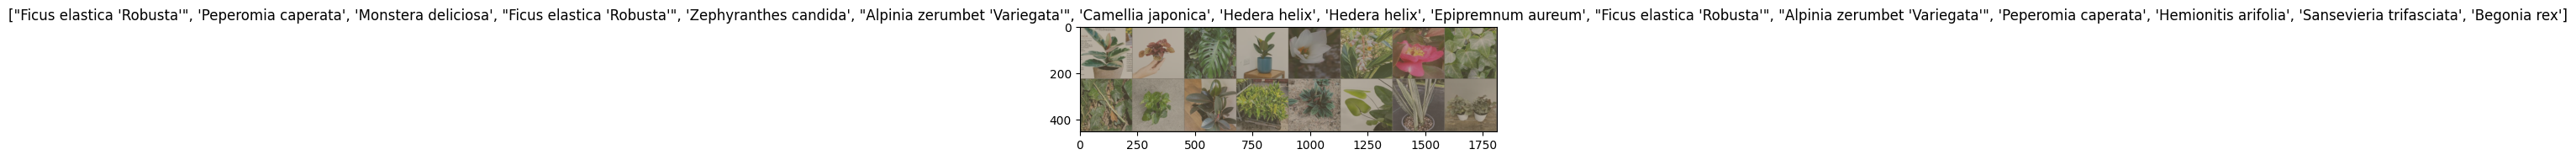

In [8]:
#학습데이터를 배치단위로 불러오기
iterator = iter(train_dataloader)

#시각화 
class_names = train_datasets.classes
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [9]:
model = models.resnet152(pretrained=True)
num_features = model.fc.in_features
# 전이 학습(transfer learning): 모델의 출력 뉴런 수를 3개로 교체하여 마지막 레이어 다시 학습
model.fc = nn.Linear(num_features, 48)
model = model.to(device)

C:\Users\User\anaconda3\envs\torch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\torch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to C:\Users\User/.cache\torch\hub\checkpoints\resnet152-394f9c45.pth
100%|███████████████████████████████████████████████████████████████████████████████| 230M/230M [00:04<00:00, 53.2MB/s]


In [10]:
#손실함수로 크로스엔트로피 
criterion = nn.CrossEntropyLoss()
#매개변수 학습방법으로 Adam, learning rate 0.0005
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [14]:

#from torch.utils.tensorboard import SummaryWriter
import numpy as np

#writer = SummaryWriter()

num_epochs = 50
model.train()
start_time = time.time()

# 전체 반복(epoch) 수 만큼 반복하며
for epoch in range(num_epochs):
    print("epoch: ", epoch)
    running_loss = 0.
    running_corrects = 0

    # 배치 단위로 학습 데이터 불러오기
    for i, data in tqdm.tqdm(enumerate(train_dataloader,0)):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 모델에 입력(forward)하고 결과 계산
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

          #  ...학습 중 손실(running loss)을 기록하고
#         writer.add_scalar('training loss',
#                         running_loss / 1000,
#                         epoch * len(train_dataloader) + i)

       # ...무작위 미니배치(mini-batch)에 대한 모델의 예측 결과를 보여주도록
       # Matplotlib Figure를 기록합니다
#         writer.add_figure('predictions vs. actuals',
#                         plot_classes_preds(model, inputs, labels),
#                         global_step=epoch * len(train_dataloader) + i)
        running_loss = 0.0

    epoch_loss = running_loss / len(train_datasets)
    epoch_acc = running_corrects / len(train_datasets) * 100.

    # 학습 과정 중에 결과 출력
    print('#{} Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

epoch:  0


3439it [04:08, 13.86it/s]


#0 Loss: 0.0000 Acc: 57.6058% Time: 252.9195s
epoch:  1


3439it [04:08, 13.84it/s]


#1 Loss: 0.0000 Acc: 72.3286% Time: 506.1609s
epoch:  2


3439it [04:06, 13.95it/s]


#2 Loss: 0.0000 Acc: 78.0922% Time: 757.8082s
epoch:  3


3439it [04:07, 13.92it/s]


#3 Loss: 0.0000 Acc: 81.9419% Time: 1009.6476s
epoch:  4


3439it [04:08, 13.84it/s]


#4 Loss: 0.0000 Acc: 84.6484% Time: 1263.0078s
epoch:  5


3439it [04:07, 13.88it/s]


#5 Loss: 0.0000 Acc: 87.0931% Time: 1515.7300s
epoch:  6


3439it [04:10, 13.72it/s]


#6 Loss: 0.0000 Acc: 89.3088% Time: 1771.2080s
epoch:  7


3439it [04:11, 13.65it/s]


#7 Loss: 0.0000 Acc: 91.1318% Time: 2028.1868s
epoch:  8


3439it [04:12, 13.61it/s]


#8 Loss: 0.0000 Acc: 92.5714% Time: 2285.7455s
epoch:  9


3439it [04:12, 13.62it/s]


#9 Loss: 0.0000 Acc: 93.7601% Time: 2543.1422s
epoch:  10


3439it [04:13, 13.56it/s]


#10 Loss: 0.0000 Acc: 94.2654% Time: 2801.6202s
epoch:  11


3439it [04:08, 13.82it/s]


#11 Loss: 0.0000 Acc: 95.2106% Time: 3055.4691s
epoch:  12


3439it [04:07, 13.87it/s]


#12 Loss: 0.0000 Acc: 95.5268% Time: 3308.2347s
epoch:  13


3439it [04:08, 13.82it/s]


#13 Loss: 0.0000 Acc: 95.9140% Time: 3561.9523s
epoch:  14


3439it [04:08, 13.82it/s]


#14 Loss: 0.0000 Acc: 96.2048% Time: 3815.8111s
epoch:  15


3439it [04:06, 13.94it/s]


#15 Loss: 0.0000 Acc: 96.3866% Time: 4067.3878s
epoch:  16


3439it [04:06, 13.95it/s]


#16 Loss: 0.0000 Acc: 96.7356% Time: 4318.7566s
epoch:  17


3439it [04:06, 13.95it/s]


#17 Loss: 0.0000 Acc: 96.8083% Time: 4570.2249s
epoch:  18


3439it [04:06, 13.96it/s]


#18 Loss: 0.0000 Acc: 97.1881% Time: 4821.5019s
epoch:  19


3439it [04:06, 13.95it/s]


#19 Loss: 0.0000 Acc: 97.0118% Time: 5072.9953s
epoch:  20


3439it [04:06, 13.95it/s]


#20 Loss: 0.0000 Acc: 97.3626% Time: 5324.3866s
epoch:  21


3439it [04:06, 13.96it/s]


#21 Loss: 0.0000 Acc: 97.3608% Time: 5575.7094s
epoch:  22


3439it [04:06, 13.95it/s]


#22 Loss: 0.0000 Acc: 97.6480% Time: 5827.1430s
epoch:  23


3439it [04:06, 13.94it/s]


#23 Loss: 0.0000 Acc: 97.7353% Time: 6078.7204s
epoch:  24


3439it [04:06, 13.95it/s]


#24 Loss: 0.0000 Acc: 97.8061% Time: 6330.1463s
epoch:  25


3439it [04:06, 13.95it/s]


#25 Loss: 0.0000 Acc: 97.6953% Time: 6581.5994s
epoch:  26


3439it [04:06, 13.95it/s]


#26 Loss: 0.0000 Acc: 97.8843% Time: 6833.0295s
epoch:  27


3439it [04:06, 13.95it/s]


#27 Loss: 0.0000 Acc: 97.9261% Time: 7084.5085s
epoch:  28


3439it [04:06, 13.95it/s]


#28 Loss: 0.0000 Acc: 98.0388% Time: 7335.9544s
epoch:  29


3439it [04:06, 13.93it/s]


#29 Loss: 0.0000 Acc: 98.1442% Time: 7587.8344s
epoch:  30


3439it [04:06, 13.94it/s]


#30 Loss: 0.0000 Acc: 98.1569% Time: 7839.4170s
epoch:  31


3439it [04:06, 13.96it/s]


#31 Loss: 0.0000 Acc: 98.0806% Time: 8090.6685s
epoch:  32


3439it [04:06, 13.95it/s]


#32 Loss: 0.0000 Acc: 98.1951% Time: 8342.1050s
epoch:  33


3439it [04:06, 13.96it/s]


#33 Loss: 0.0000 Acc: 98.2587% Time: 8593.3336s
epoch:  34


3439it [04:06, 13.94it/s]


#34 Loss: 0.0000 Acc: 98.2333% Time: 8844.9105s
epoch:  35


3439it [04:06, 13.94it/s]


#35 Loss: 0.0000 Acc: 98.3005% Time: 9096.4318s
epoch:  36


3439it [04:06, 13.94it/s]


#36 Loss: 0.0000 Acc: 98.3260% Time: 9348.0474s
epoch:  37


3439it [04:06, 13.94it/s]


#37 Loss: 0.0000 Acc: 98.3950% Time: 9599.7079s
epoch:  38


3439it [04:06, 13.95it/s]


#38 Loss: 0.0000 Acc: 98.3860% Time: 9851.2134s
epoch:  39


3439it [04:06, 13.95it/s]


#39 Loss: 0.0000 Acc: 98.3641% Time: 10102.6923s
epoch:  40


3439it [04:06, 13.94it/s]


#40 Loss: 0.0000 Acc: 98.3805% Time: 10354.2232s
epoch:  41


3439it [04:06, 13.96it/s]


#41 Loss: 0.0000 Acc: 98.4787% Time: 10605.4625s
epoch:  42


3439it [04:06, 13.95it/s]


#42 Loss: 0.0000 Acc: 98.5186% Time: 10856.8435s
epoch:  43


3439it [04:06, 13.95it/s]


#43 Loss: 0.0000 Acc: 98.4550% Time: 11108.3670s
epoch:  44


3439it [04:06, 13.94it/s]


#44 Loss: 0.0000 Acc: 98.5077% Time: 11359.9406s
epoch:  45


3439it [04:06, 13.94it/s]


#45 Loss: 0.0000 Acc: 98.5096% Time: 11611.5365s
epoch:  46


3439it [04:06, 13.94it/s]


#46 Loss: 0.0000 Acc: 98.5695% Time: 11863.1905s
epoch:  47


3439it [04:06, 13.95it/s]


#47 Loss: 0.0000 Acc: 98.6077% Time: 12114.6000s
epoch:  48


3439it [04:06, 13.97it/s]


#48 Loss: 0.0000 Acc: 98.6586% Time: 12365.7367s
epoch:  49


3439it [04:06, 13.95it/s]

#49 Loss: 0.0000 Acc: 98.6750% Time: 12617.1423s


[예측 결과: Cyrtomium falcatum] (실제 정답: Cyrtomium falcatum)
(224, 224, 3)
[예측 결과: Clivia miniata] (실제 정답: Clivia miniata)
(224, 224, 3)
[예측 결과: Aspidistra elatior] (실제 정답: Aspidistra elatior)
(224, 224, 3)
[예측 결과: Epipremnum aureum] (실제 정답: Epipremnum aureum)
(224, 224, 3)
[예측 결과: Epipremnum aureum] (실제 정답: Philodendron 'Xanadu')
(224, 224, 3)
[예측 결과: Impatiens hybrid 'New Guinea'] (실제 정답: Impatiens hybrid 'New Guinea')
(224, 224, 3)
[예측 결과: Monstera deliciosa] (실제 정답: Philodendron 'Xanadu')
(224, 224, 3)
[예측 결과: Pilea cadierei] (실제 정답: Sansevieria trifasciata)
(224, 224, 3)
[예측 결과: Acorus gramineus] (실제 정답: Chlorophytum comosum)
(224, 224, 3)
[예측 결과: Euphorbia pulcherrima] (실제 정답: Euphorbia pulcherrima)
(224, 224, 3)
[예측 결과: Camellia japonica] (실제 정답: Camellia japonica)
(224, 224, 3)
[예측 결과: Begonia rex] (실제 정답: Rumohra adiantiformis)
(224, 224, 3)
[예측 결과: Calathea makoyana] (실제 정답: Calathea makoyana)
(224, 224, 3)
[예측 결과: Platycerium bifurcatum] (실제 정답: Platycerium bifurcatum)
(224, 224,

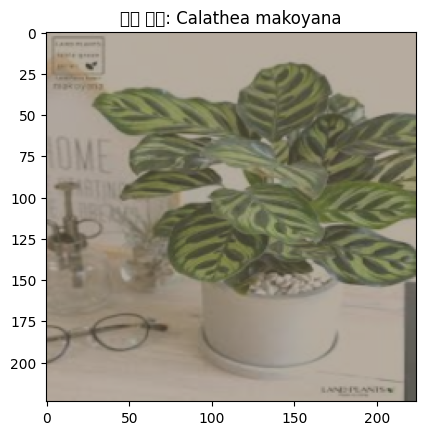

In [17]:
#테스트 데이터로 모델 평가하는 코드 
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    #테스트 데이터셋으로 모델 평가
    for inputs, labels in test_dataloader:
        #학습한 것과 동일하게 손실함수 구한다
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        # 한 배치의 첫 번째 이미지에 대하여 결과 시각화
        print(f'[예측 결과: {class_names[preds[0]]}] (실제 정답: {class_names[labels.data[0]]})')
        imshow(inputs.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])

    epoch_loss = running_loss / len(test_datasets)
    epoch_acc = running_corrects / len(test_datasets) * 100.
    print('[Test Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))

In [16]:
torch.save(model,'C:/Users/User/Desktop/plantdata/model_resnet152.h5')